# Model Selection using RFE (Recursive Feature Elimination)

# Housing price case study

### Importing and Understanding Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Importing Housing.csv
housing = pd.read_csv('Housing.csv')

In [3]:
# looking at the first five rows of the housing data
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [4]:
# Looking at the last five rows of the housing data
housing.tail()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished
544,1750000,3850,3,1,2,yes,no,no,no,no,0,no,unfurnished


### Data Preparation

In [5]:
# Converting Yes to 1 and No to 0
housing['mainroad'] = housing['mainroad'].map({'yes' : 1, 'no' : 0})
housing['guestroom'] = housing['guestroom'].map({'yes' : 1, 'no' : 0})
housing['basement'] = housing['basement'].map({'yes' : 1, 'no' : 0})
housing['hotwaterheating'] = housing['hotwaterheating'].map({'yes' : 1, 'no' : 0})
housing['airconditioning'] = housing['airconditioning'].map({'yes' : 1, 'no' : 0})
housing['prefarea'] = housing['prefarea'].map({'yes' : 1, 'no' : 0})

In [6]:
# Creating dummy variable for variable frunishingstatus and dropping the first one
status = pd.get_dummies(housing['furnishingstatus'], drop_first = True)

In [7]:
# Adding the results to the master dataframe
housing = pd.concat([housing, status], axis=1)

In [8]:
# Dropping the variable furnishingstatus
housing.drop(['furnishingstatus'], axis=1, inplace = True)

### Creating a new variable

In [9]:
# Let's create the new metric and assign it to 'areaperbedroom'
housing['areaperbedroom'] = housing['area'] / housing['bedrooms']

In [10]:
# Metric: bathrooms per bedroom
housing['bbratio'] = housing['bathrooms'] / housing['bedrooms']

### Rescalling the features

It is extremely important to rescale the variables so that they have a comparable scale. There are two ways of rescalling

    1. Normalization (min-max scalling) and
    2. standardisation (mean-o, sigma-1)

Let's try normalization

In [11]:
# defining a normalization function

def normalize(x):
    return (x - np.min(x)) / (max(x) - min(x))

# applying normalize() to all columns
housing = housing.apply(normalize)

### Splitting data into traning and testing sets

In [17]:
print(housing.columns)

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'semi-furnished', 'unfurnished',
       'areaperbedroom', 'bbratio'],
      dtype='object')


In [18]:
# Putting features variable to x
X = housing[['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'semi-furnished', 'unfurnished',
       'areaperbedroom', 'bbratio']]

# Putting response variable to y
y = housing['price']

In [19]:
# random state is the seed used by the random number generator, it can be any integer.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state = 100)

In [20]:
# calculating Vif value
def vif_cal(input_data, dependent_col):
    vif_df = pd.DataFrame( columns = ['Var', 'Vif'])
    x_vars = input_data.drop([dependent_col], axis=1)
    xvar_names = x_vars.columns
    
    for i in range(0, xvar_names.shape[0]):
        y = x_vars[xvar_names[i]]
        x = x_vars[xvar_names.drop(xvar_names[i])]
        rsq = sm.OLS(y, x).fit().rsquared
        vif = round(1/(1-rsq), 2)
        vif_df.loc[i] = [xvar_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis=0, ascending=False, inplace=False)

### RFE

In [21]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [24]:
# Running RFE with the output number of the variable equal to 9
lm = LinearRegression()

# rfe uses greedy approach and look at the best 9 particular columns which we can have, it will automatically do it.
rfe = RFE(lm, 9) # running RFE
# building our model using fit method
rfe = rfe.fit(X_train, y_train)

print(rfe.support_) # Printing the boolean results
print(rfe.ranking_)

# All True are the best features and all the False it have rejected.

[ True False  True  True  True False False  True  True False  True False
 False  True  True]
[1 3 1 1 1 4 6 1 1 2 1 7 5 1 1]


In [26]:
col = X_train.columns[rfe.support_]

### Building model using sklearn

In [27]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [28]:
# Adding a constant variable
import statsmodels.api as sm
X_train_rfe = sm.add_constant(X_train_rfe)

C:\Users\d33ps3curity\AppData\Local\Programs\Python\Python37-32\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [29]:
lm = sm.OLS(y_train, X_train_rfe).fit() # Running the linear model

In [42]:
housing.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'semi-furnished', 'unfurnished',
       'areaperbedroom', 'bbratio'],
      dtype='object')

In [30]:
# Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     80.14
Date:                Sun, 29 Sep 2019   Prob (F-statistic):           1.88e-81
Time:                        00:58:32   Log-Likelihood:                 369.54
No. Observations:                 381   AIC:                            -719.1
Df Residuals:                     371   BIC:                            -679.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0139      0.021     

In [43]:
# Calculating Vif value
vif_cal(input_data=housing.drop(['area', 'bedrooms', 'stories', 'basement', 'semi-furnished', 'areaperbedroom'], axis=1), dependent_col='price')

,Var,Vif
8,bbratio,6.21
1,mainroad,4.66
0,bathrooms,2.78
5,parking,1.82
4,airconditioning,1.59
7,unfurnished,1.44
6,prefarea,1.41
2,guestroom,1.28
3,hotwaterheating,1.08


## Making Predictions

In [44]:
# Now let's use our model to make predictions.

# Creating X_test_6 dataframe by dropping variables from X_test
X_test_rfe = X_test[col]

# Adding a constant variable
X_test_rfe = sm.add_constant(X_test_rfe)

# Making predictions
y_pred = lm.predict(X_test_rfe)

C:\Users\d33ps3curity\AppData\Local\Programs\Python\Python37-32\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


# Model Evaluation

In [45]:
# Now let's check how well our model is able to make predictions

# Importing the required libraries for plots.
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0, 0.5, 'House Price')

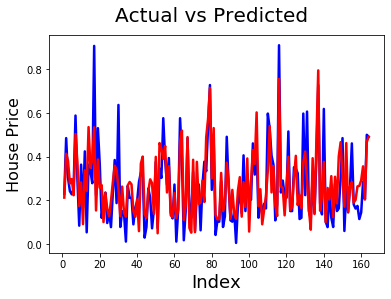

In [47]:
# Actual and Predicted
c = [i for i in range(1, 165 ,1)]
fig = plt.figure()
plt.plot(c, y_test, color='blue', linewidth=2.5, linestyle='-')
plt.plot(c, y_pred, color='red', linewidth=2.5, linestyle='-')
fig.suptitle('Actual vs Predicted', fontsize=20)
plt.xlabel('Index', fontsize=18)
plt.ylabel('House Price', fontsize=16)

Text(0, 0.5, 'y_test - y_pred')

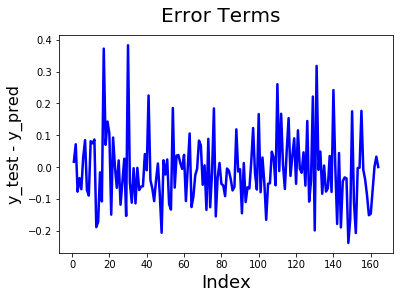

In [48]:
# Error Terms
c = [i for i in range(1, 165 ,1)]
fig = plt.figure()
plt.plot(c, y_test - y_pred, color='blue', linewidth=2.5, linestyle='-')
fig.suptitle('Error Terms', fontsize=20)
plt.xlabel('Index', fontsize=18)
plt.ylabel('y_test - y_pred', fontsize=16)

Text(0, 0.5, 'y_pred')

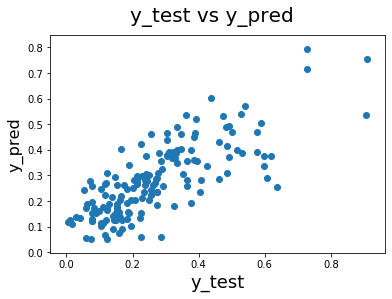

In [50]:
# Plotting y_test and y_pred to understand the spread.
c = [i for i in range(1, 165 ,1)]
fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)
plt.xlabel('y_test', fontsize=18)
plt.ylabel('y_pred', fontsize=16)

Text(0, 0.5, 'Index')

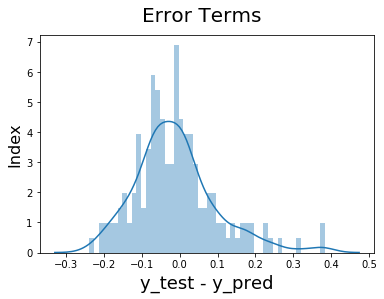

In [52]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
sns.distplot(y_test - y_pred, bins=50)
fig.suptitle('Error Terms', fontsize=20)
plt.xlabel('y_test - y_pred', fontsize=18)
plt.ylabel('Index', fontsize=16)

In [ ]:
# Now let's check the Root Mean Square Error of our model.
import numpy as np
from sklearn import metrics
print('RMSE : ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))